In [2]:
from lightgbm import LGBMRegressor,LGBMClassifier

import gc

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from ImportData_EDAFeatures import CreateDF_UntilEDA
from HigherOrderFeatures import CreateDF_UntilHOFE

import shap

np.seterr(divide = 'ignore')
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
# suppress warnings
warnings.filterwarnings('ignore')

In [3]:
def return_interaction(interaction_df):
    result = {}
    
    for col in interaction_df.columns:
        for indx in interaction_df[col].index:
            value_get = round(interaction_df[interaction_df.index == indx][col].values[0],2)
            if (col + ' and ' + indx not in result.keys()) and (indx + ' and ' + col not in result.keys()) and value_get >=0.1 and (col.split("_")[0]!=indx.split("_")[0]):
                result[col + ' and ' + indx] = value_get              

    return result
def calculate_mean_result_dict(result_dict):
    
    if len(result_dict.keys()) ==0:
        return {}
    
    temp_result_dict = {}
    for key in result_dict.keys():
        for key2 in result_dict[key].keys():
            if key2 not in temp_result_dict.keys():
                temp_result_dict[key2] = [result_dict[key][key2]]
            else:
                temp_result_dict[key2].append(result_dict[key][key2])

    #calculate average
    mean_result_dict = {}
    for key in temp_result_dict.keys():
        mean_result_dict[key] = round(np.mean(temp_result_dict[key]),2)

    #sort by values
    mean_result_dict = dict(sorted(mean_result_dict.items(), key=lambda item: item[1]))

    return mean_result_dict

def common_list_interactions(result_dict):
    
    if len(result_dict.keys()) ==0:
        return []

    common_interaction_list = list(set(result_dict[0].keys()).intersection(set(result_dict[1].keys())).intersection(set(result_dict[2].keys())).intersection(set(result_dict[3].keys())).intersection(set(result_dict[4].keys())))
    
    print('\nInteraction present across all cross-validation: '+str(len(common_interaction_list)))

    return common_interaction_list

def get_common_interactions(data_dict,categorical_tree,numerical_features_tree,ordinal_features_engineered,model):
    result_dict = {}
    for data_fold_index in data_dict['fold_dict'].keys():
        print('data_fold_index:',data_fold_index)
        X = data_dict['fold_dict'][data_fold_index]['fold_training'][categorical_tree+numerical_features_tree+ordinal_features_engineered]
        Y = data_dict['fold_dict'][data_fold_index]['fold_training'][dependent_variable]
        
        if model == 'regression':
            #train model
            tree_model = LGBMRegressor(random_state=1)
            tree_model.fit(X,Y)
        else:
            #train model
            tree_model = LGBMClassifier(random_state=1)
            tree_model.fit(X,Y)

        #tree SHAP
        tree_explainer = shap.TreeExplainer(tree_model)
        tree_FeatureInteraction = tree_explainer.shap_interaction_values(X)

        #find interactions
        mean_interaction = np.abs(tree_FeatureInteraction).mean(0)
        interaction = pd.DataFrame(mean_interaction,index=X.columns,columns=X.columns)
        interaction.where(interaction.values == np.diagonal(interaction),interaction.values*2,inplace=True)
        result = return_interaction(interaction)
        
        del X
        del Y
        del tree_model
        del tree_explainer
        del tree_FeatureInteraction
        del mean_interaction
        del interaction
        gc.collect()
        
        result_dict[data_fold_index] = result
        if len(result.keys()) ==0:
            return {}
        print('Total interactions:'+str(len(result.keys())))
        
    #find interactions present across all cross-validations
    return result_dict

def make_plot(fivepairs):
    sns.set(rc={'figure.figsize':(10,10)})
    sns.set_context('paper', font_scale = 1.3)

    keys = list(fivepairs.keys())
    vals = list(fivepairs.values())
    sns.barplot(x=keys, y=vals,color='grey')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


### CarSales

In [4]:
'HotelCancellations', 'CouponRecommendation', 'PredictRoomBooking','CarSales'
problem = 'CarSales'
dataset,dependent_variable,numerical_features,categorical_features = CreateDF_UntilEDA(problem)
data_dict,categorical_linear,categorical_tree,categorical_features,numerical_features_linear,numerical_features_tree,ordinal_features,ordinal_features_engineered = CreateDF_UntilHOFE(dataset,dependent_variable,numerical_features,categorical_features,dataset_name=problem)

result_dict_car = get_common_interactions(data_dict,categorical_tree,numerical_features_tree,ordinal_features_engineered,model='regression')
common_interaction_list_car = common_list_interactions(result_dict_car)
mean_result_dict_car = calculate_mean_result_dict(result_dict_car)

data_fold_index: 0
Total interactions:107
data_fold_index: 1
Total interactions:122
data_fold_index: 2
Total interactions:118
data_fold_index: 3
Total interactions:133
data_fold_index: 4
Total interactions:122

Interaction present across all cross-validation: 99


In [4]:
first5pairs = {k: mean_result_dict_car[k] for k in list(mean_result_dict_car)[:5]}
lastt5pairs = {k: mean_result_dict_car[k] for k in list(mean_result_dict_car)[-5:]}

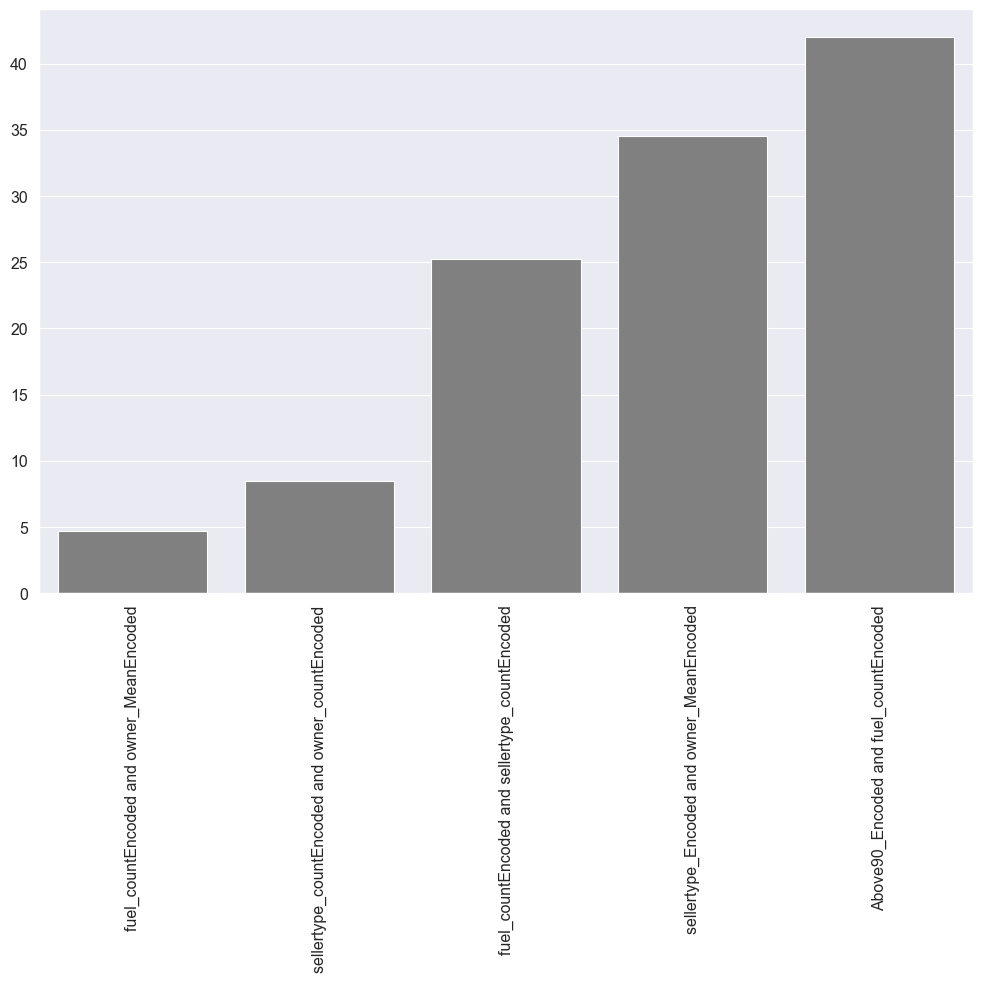

In [8]:
make_plot(first5pairs)

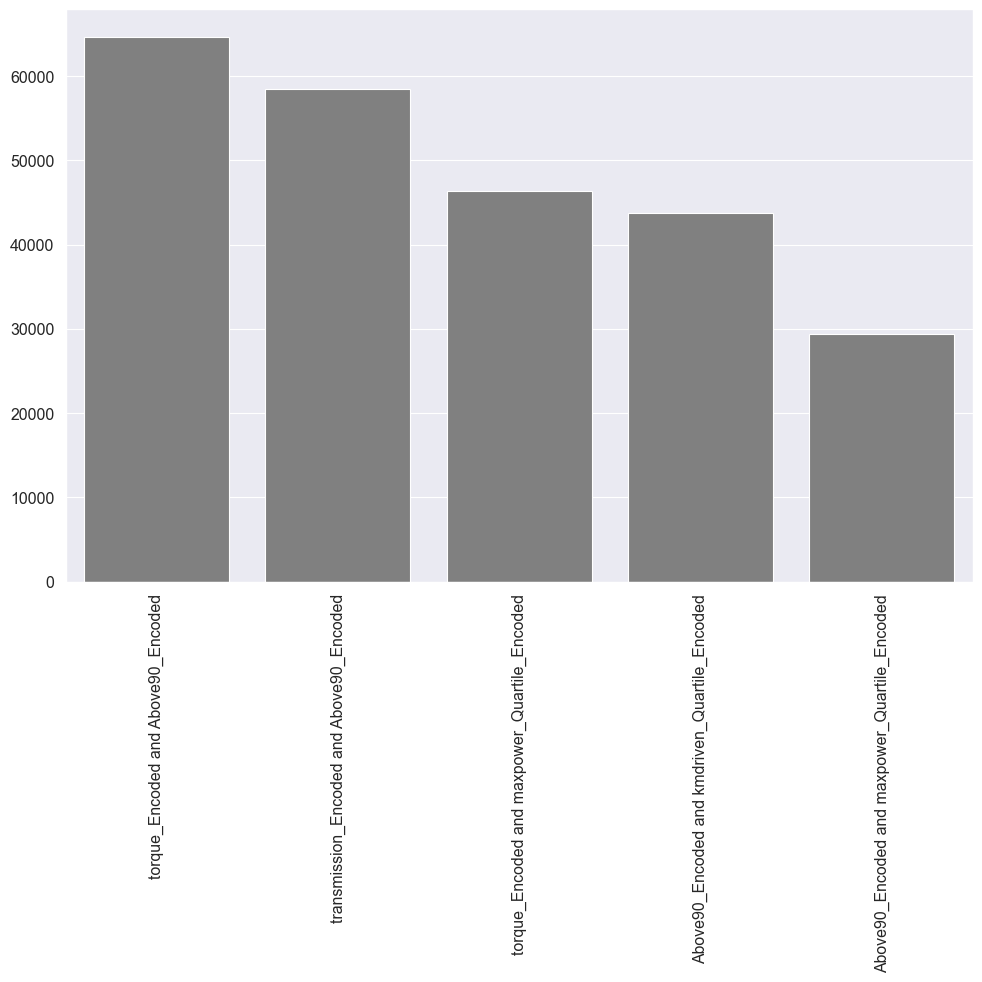

In [9]:
lastt5pairs = dict(sorted(lastt5pairs.items(), key=lambda item: item[1],reverse=True))
make_plot(lastt5pairs)

### Coupon Recommendation

In [10]:
'HotelCancellations', 'CouponRecommendation', 'PredictRoomBooking','CarSales'
problem = 'CouponRecommendation'
dataset,dependent_variable,numerical_features,categorical_features = CreateDF_UntilEDA(problem)
data_dict,categorical_linear,categorical_tree,categorical_features,numerical_features_linear,numerical_features_tree,ordinal_features,ordinal_features_engineered = CreateDF_UntilHOFE(dataset,dependent_variable,numerical_features,categorical_features,dataset_name=problem)

result_dict_coupon = get_common_interactions(data_dict,categorical_tree,numerical_features_tree,ordinal_features_engineered,model='')
common_interaction_list_coupon = common_list_interactions(result_dict_coupon)
mean_result_dict_coupon = calculate_mean_result_dict(result_dict_coupon)
mean_result_dict_coupon

data_fold_index: 0
Total interactions:4
data_fold_index: 1
Total interactions:3
data_fold_index: 2
Total interactions:4
data_fold_index: 3
Total interactions:3
data_fold_index: 4
Total interactions:5

Interaction present across all cross-validation: 2


{'coupon_Encoded and Bar_Encoded': 0.1,
 'Bar_Encoded and coupon_countEncoded': 0.1,
 'weather_Encoded and coupon_MeanEncoded': 0.1,
 'expiration_Encoded and coupon_MeanEncoded': 0.12,
 'CoffeeHouse_Encoded and coupon_countEncoded': 0.15,
 'CoffeeHouse_Encoded and coupon_MeanEncoded': 0.16}

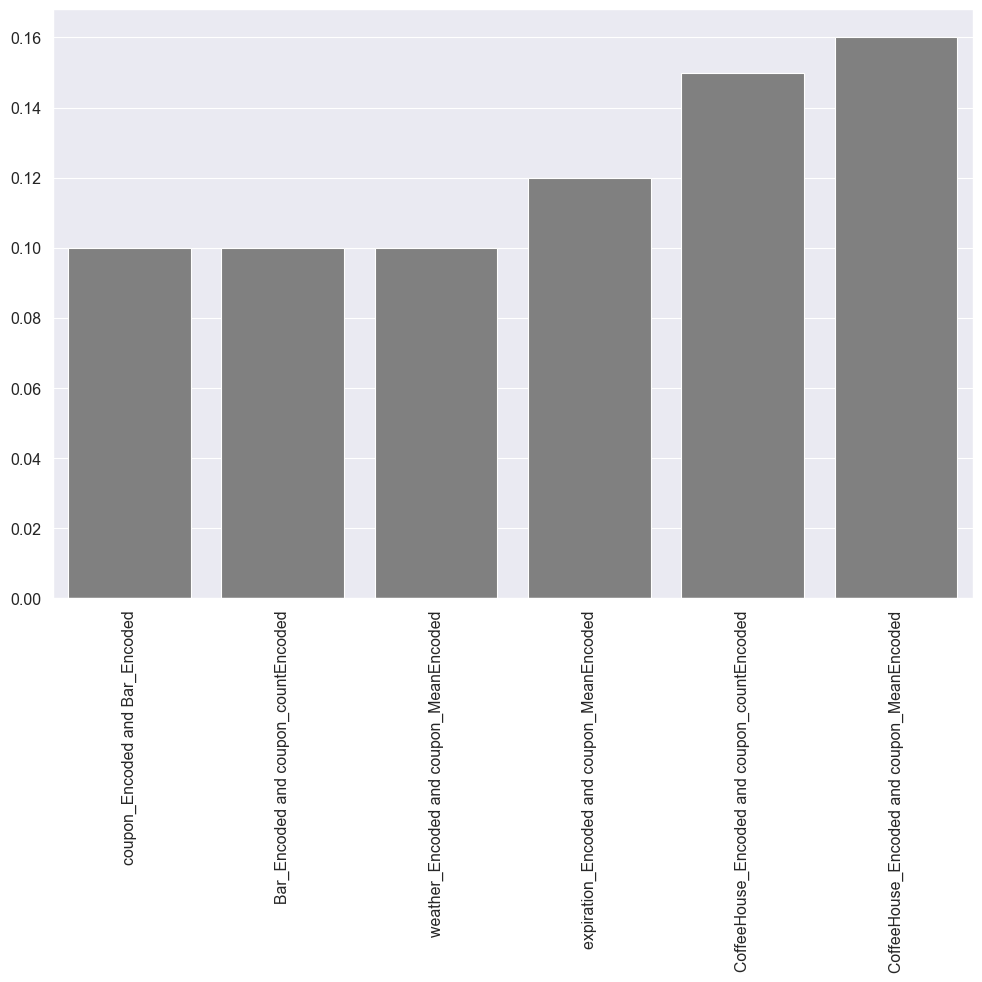

In [11]:
make_plot(mean_result_dict_coupon)